In [ ]:
import numpy as np
import cvxpy as cvx
import control as ctrl
import scipy.linalg as linalg
import matplotlib.pyplot as plt

from lib.utils import build_lure_system
from lib.algorithms_constrained import *

In [7]:
# Matplotlib settings
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

### Show $\mathcal{O}(\mathcal{P}_T)$ regret

In [19]:
def show_PT_with_SDP(algo, m, L):

    eps = 1e-6

    G, p, q = algo

    # Get algorithm dimensions
    n_xi = G.nstates
    n_x  = G.noutputs

    # build Lur'e system
    A_hat, B_hat, C_hat, D_hat, M = build_lure_system(G, m, L, p, q, vIQC=False)

    # get dimensions
    n_eta = A_hat.shape[0]
    n_z = M.shape[0]

    # SDP variables
    P      = cvx.Variable((n_eta, n_eta), symmetric=True)
    t      = cvx.Variable(1, nonneg=True)
    lambds_p = [cvx.Variable(1, nonneg=True) for _ in range(p)]
    lambds_q = [cvx.Variable(1, nonneg=True) for _ in range(q)]

    # LMI
    Z_eta = np.zeros((n_eta, n_eta))
    Z_z   = np.zeros((n_z, n_z))
    Z_x   = np.zeros((n_x,n_x))

    C_0 = np.block([[G.C[:1,:]],[np.zeros(G.C[1:,:].shape)]])

    LMI1 = cvx.bmat([[A_hat.T @ P @ A_hat - P,   A_hat.T @ P @ B_hat],
                     [B_hat.T @ P @ A_hat,       B_hat.T @ P @ B_hat]])
    LMI2 = np.block([[Z_eta,   C_0.T],
                     [C_0,       Z_x]])
    LMI3 = np.block([[C_hat, D_hat]])

    lambdas = lambds_p + lambds_q
    total_blocks = len(lambdas)
    Multiplier = cvx.bmat([[lambdas[i] * M if i == j else Z_z for j in range(total_blocks)] for i in range(total_blocks)])

    LMI = LMI1 + LMI3.T @ Multiplier @ LMI3 + LMI2

    # Solve problem
    problem = cvx.Problem(cvx.Minimize(t), [LMI << 0, P >> eps*np.eye(n_eta), P << cvx.multiply(t, np.eye(n_eta))])
    try:
        problem.solve(solver=cvx.MOSEK)
    except(cvx.SolverError):
        pass

    flag = problem.status
    return flag, P.value

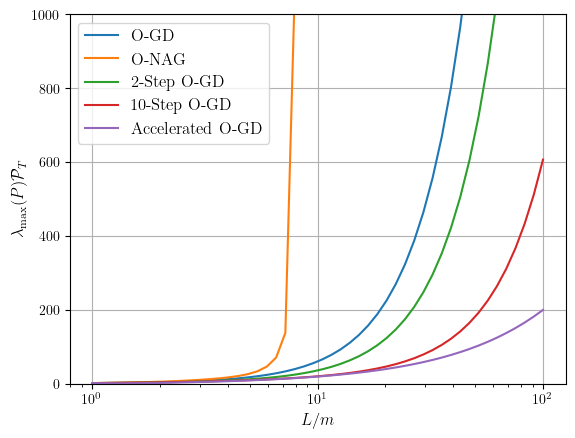

In [ ]:
algorithms = {
    "O-GD"             :  {"callable": proximal_gradient, "kappas": list(), "bound": list()},
    "2-Step O-GD"      :  {"callable": lambda m,L: multi_step_ogd(m,L,K=2), "kappas": list(), "bound": list()},
    "10-Step O-GD"     :  {"callable": lambda m,L: multi_step_ogd(m,L,K=10), "kappas": list(), "bound": list()},
    "O-NAG"            :  {"callable": proximal_nesterov, "kappas": list(), "bound": list()},
    "O-TMM"            :  {"callable": proximal_triple_momentum, "kappas": list(), "bound": list()},
    "Accelerated O-GD" :  {"callable": accelerated_ogd, "kappas": list(), "bound": list()}
}

algos = algorithms.keys()
kappas = np.logspace(0,2,50)

# foresight knowledge
P_T = 1

plt.figure(1)
plt.xlabel(r'$L/m$')
plt.ylabel(r'$\lambda_{\max}(P) \mathcal{P}_T$')
plt.ylim([0,1000])
plt.grid(True)

for name, algo_dict in algorithms.items():

    for kappa in kappas:

        G = algo_dict["callable"](1,kappa)
        flag, P = show_PT_with_SDP(algo=G, m=1, L=kappa)

        if flag is cvx.OPTIMAL:
            # feasible! Save result
            algorithms[name]["kappas"].append(kappa)
            algorithms[name]["bound"].append(np.max(np.linalg.eigvalsh(P))*P_T)

    plt.semilogx(algorithms[name]["kappas"], algorithms[name]["bound"], label=name)

plt.legend()
plt.show()

### Show $\mathcal{O}(\mathcal{S}_T + \mathcal{V}_T)$ regret

- $\mathcal{O}(\mathcal{S}_T)$ if ``vIQC = False``
- $\mathcal{O}(\mathcal{S}_T + \mathcal{V}_T)$ if ``vIQC = True``

In [26]:
def show_ST_VT_with_SDP(algo, m, L, vIQC=True, VT=1, ST=1):

    eps = 1e-6

    G, p, q = algo

    # Get algorithm dimensions
    n_xi = G.nstates
    n_x  = G.noutputs

    # build Lur'e system
    A_hat, B_hat, C_hat, D_hat, M = build_lure_system(G, m, L, p, q, vIQC)

    # get dimensions
    n_eta = A_hat.shape[0]
    n_psi = C_hat.shape[0]
    n_zeta = n_eta - n_xi
    n_z = M.shape[0]

    # augment with Delta
    B_Delta = np.block([[np.eye(n_xi)], [G.C[:p]], [np.zeros(G.C[p:].shape)]]) if vIQC else np.eye(n_xi)
    D_Delta = np.zeros((n_psi, n_xi))

    # SDP variables
    P      = cvx.Variable((n_eta, n_eta), symmetric=True)
    t      = cvx.Variable(1, nonneg=True)
    gamm   = cvx.Variable(1, nonneg=True)
    lambds_p_sector = [cvx.Variable(1, nonneg=True) for _ in range(p)]
    lambds_q_sector = [cvx.Variable(1, nonneg=True) for _ in range(q)]
    lambds_p_offby1 = [cvx.Variable(1, nonneg=True) for _ in range(p)] if vIQC else []
    lambds_q_offby1 = [cvx.Variable(1, nonneg=True) for _ in range(q)] if vIQC else []

    # LMI
    Z_eta = np.zeros((n_eta, n_eta))
    Z_g   = np.zeros((n_x, n_x))
    Z_z   = np.zeros((n_z, n_z))

    C_x = np.block([[G.C[:1,:]],[np.zeros(G.C[1:,:].shape)]])

    C_0 = np.block([[C_x, np.zeros((n_x,n_zeta))]])

    lambdas = lambds_p_sector + lambds_q_sector + lambds_p_offby1 + lambds_q_offby1
    total_blocks = len(lambdas)
    Multiplier = cvx.bmat([[lambdas[i] * M if i == j else Z_z for j in range(total_blocks)] for i in range(total_blocks)])

    LMI_inner = cvx.bmat([[-P, np.zeros((n_eta, n_eta)), np.zeros((n_eta, n_psi)), np.zeros((n_eta, n_xi))],
                          [np.zeros((n_eta, n_eta)), P, np.zeros((n_eta, n_psi)), np.zeros((n_eta, n_xi))],
                          [np.zeros((n_psi, n_eta)), np.zeros((n_psi, n_eta)), Multiplier, np.zeros((n_psi, n_xi))], 
                          [np.zeros((n_xi, n_eta)), np.zeros((n_xi, n_eta)), np.zeros((n_xi, n_psi)), -cvx.multiply(gamm, np.eye(n_xi))]
    ])

    LMI_outer = cvx.bmat([
        [np.eye(n_eta), np.zeros((n_eta, n_x+n_xi))],
        [cvx.bmat([[A_hat, B_hat, B_Delta]])],
        [cvx.bmat([[C_hat, D_hat, D_Delta]])],
        [np.zeros((n_xi, n_eta + n_x)), np.eye(n_xi)]
    ])

    LMI_eta = np.block([[Z_eta, C_0.T],
                        [C_0,     Z_g]])
    LMI_eta = linalg.block_diag(LMI_eta, np.zeros((n_xi,n_xi)))

    LMI = LMI = LMI_outer.T @ LMI_inner @ LMI_outer + LMI_eta

    # Solve problem
    lambd_bar = cvx.sum(lambds_p_offby1)
    problem = cvx.Problem(cvx.Minimize(VT*lambd_bar + ST*gamm), [P >> eps*np.eye(n_eta), LMI << 0, P << cvx.multiply(t, np.eye(n_eta))])
    try:
        problem.solve(qcp=True, solver=cvx.MOSEK)
    except(cvx.SolverError):
        pass

    flag = problem.status
    lambd_bar = lambd_bar.value if vIQC else lambd_bar
    return flag, gamm.value, lambd_bar

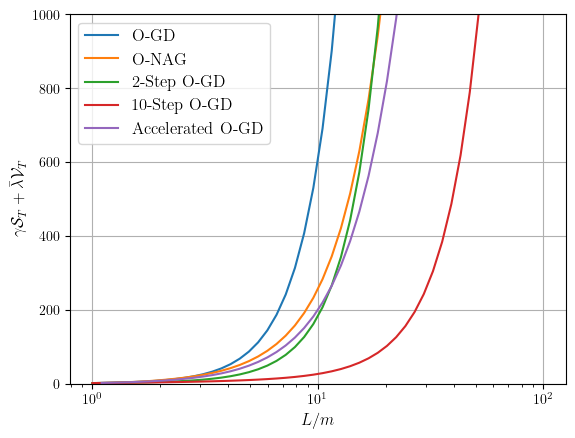

In [ ]:
### vIQC: True for S_T + V_T; False for S_T
vIQC = True

algorithms = {
    "O-GD"             :  {"callable": proximal_gradient, "kappas": list(), "bound": list()},
    "2-Step O-GD"      :  {"callable": lambda m,L: multi_step_ogd(m,L,K=2), "kappas": list(), "bound": list()},
    "10-Step O-GD"     :  {"callable": lambda m,L: multi_step_ogd(m,L,K=10), "kappas": list(), "bound": list()},
    "O-NAG"            :  {"callable": proximal_nesterov, "kappas": list(), "bound": list()},
    "O-TMM"            :  {"callable": proximal_triple_momentum, "kappas": list(), "bound": list()},
    "Accelerated O-GD" :  {"callable": accelerated_ogd, "kappas": list(), "bound": list()}
}

algos = algorithms.keys()
kappas = np.logspace(0,2,50)

plt.figure(1)
plt.xlabel(r'$L/m$')
plt.ylabel(r'$\gamma \mathcal{S}_T + \bar{\lambda} \mathcal{V}_T$')
plt.ylim([0,1000])
plt.grid(True)

# foresight knowledge
ST = 1
VT = 1

for name, algo_dict in algorithms.items():

    for kappa in kappas:

        G = algo_dict["callable"](1,kappa)
        flag, gamm, lamd_bar = show_ST_VT_with_SDP(G, m=1, L=kappa, vIQC=vIQC, VT=VT, ST=ST)

        if flag is cvx.OPTIMAL:
            # feasible! Save result
            algorithms[name]["kappas"].append(kappa)
            algorithms[name]["bound"].append(VT*lamd_bar + ST*gamm)

    plt.semilogx(algorithms[name]["kappas"], algorithms[name]["bound"], label=name)

plt.legend()
plt.show()